In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


## Load and visualize data

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [4]:
data = np.load('/kaggle/input/datasetchallengeann2/training_dataset/training_data.npy')
data.shape

(48000, 2776)

In [5]:
categories = np.load('/kaggle/input/datasetchallengeann2/training_dataset/categories.npy')
valid_indices = np.load('/kaggle/input/datasetchallengeann2/training_dataset/valid_periods.npy')
print(categories.shape)
print(valid_indices.shape)

(48000,)
(48000, 2)


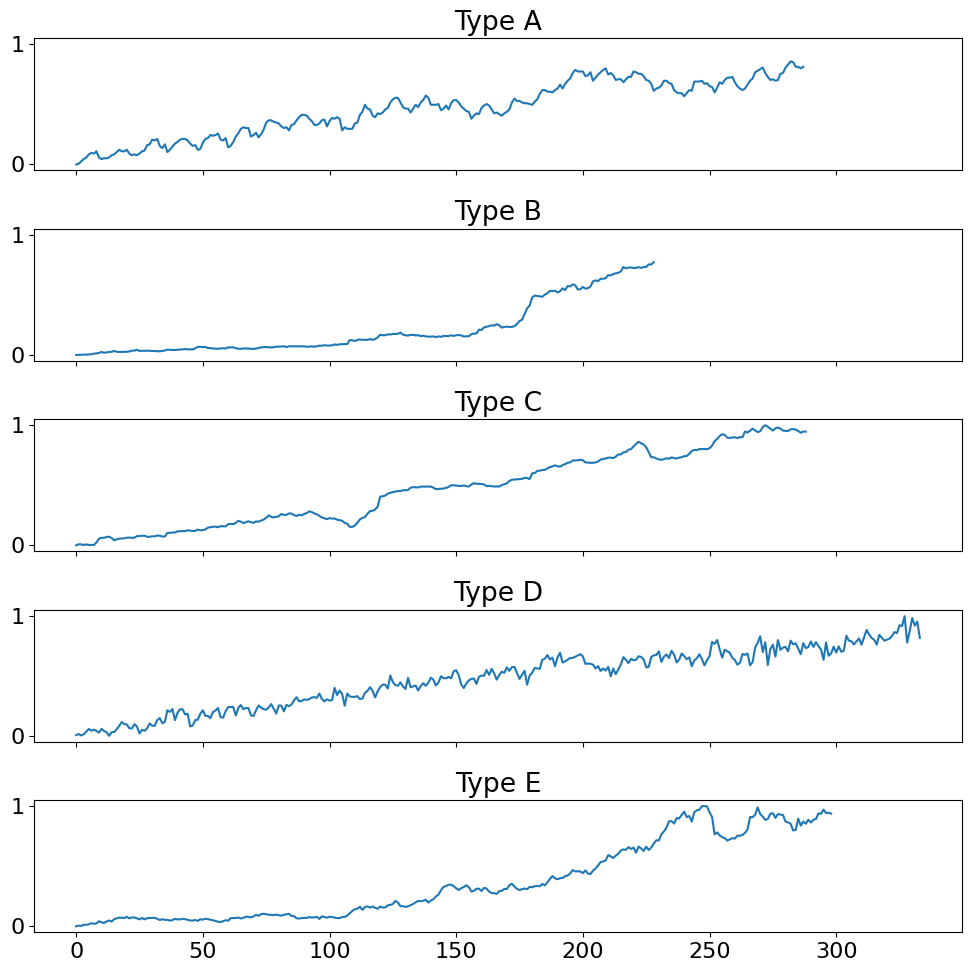

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_timeseries(data, labels, types=('A', 'B', 'C', 'D', 'E')):
    """
    Plot one random time series for each type specified in 'types'.

    Parameters:
    - data: numpy array of shape (num_time_series, time_series_length)
    - labels: numpy array of shape (num_time_series,) representing the type for each time series
    - types: tuple specifying the types to plot (default is ('A', 'B', 'C', 'D', 'E'))
    """
    # Create a figure with subplots for each type
    fig, axs = plt.subplots(len(types), 1, figsize=(10, 2 * len(types)), sharex=True, sharey=True)

    # Loop through each type and plot a random time series of that type
    for i, t in enumerate(types):
        # Get indices of time series with the specified type
        type_indices = np.where(labels == t)[0]
        
        # Select a random index for the given type
        random_index = np.random.choice(type_indices)
        
        # Extract the time series data
        time_series = data[random_index, valid_indices[random_index, 0]:]
        
        # Plot the time series
        axs[i].plot(time_series)
        axs[i].set_title(f'Type {t}')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your time series array and 'labels' is your type array
# plot_random_timeseries(data, labels)
plot_random_timeseries(data, categories)

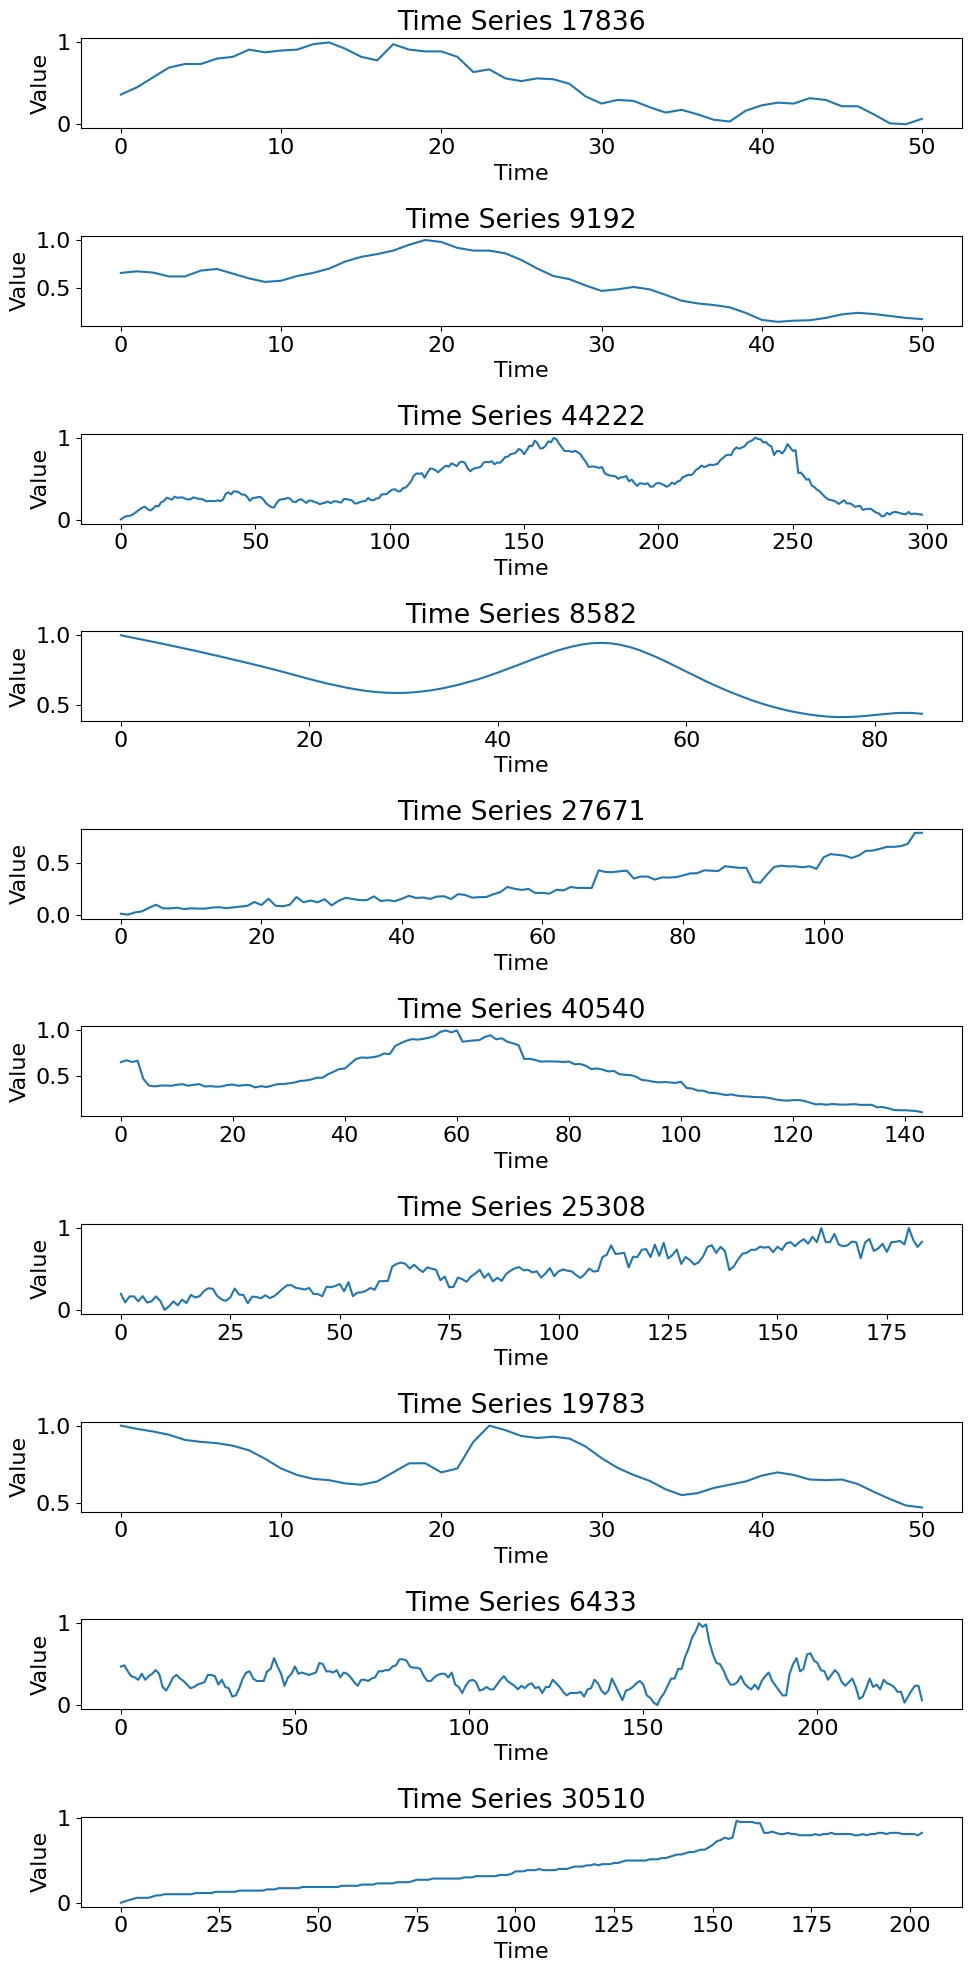

In [7]:

# Randomly select 10 time series indices
random_indices = np.random.choice(data.shape[0], 10, replace=False)

# Plot each selected time series in a separate subplot
num_plots = len(random_indices)
fig, axs = plt.subplots(num_plots, 1, figsize=(10, 2 * num_plots))

for i, index in enumerate(random_indices):
    axs[i].plot(data[index, valid_indices[index, 0]:])
    axs[i].set_title(f'Time Series {index}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

## Split data and build sequences 

In [8]:
count_inspect= 0
def build_sequences(df, window=100, stride=20, telescope=100):
    global count_inspect 
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    df = np.expand_dims(df, axis = -1)
    temp_df = np.copy(df)
    padding_check = len(df)%(window+telescope)
    
    if(padding_check != 0):
        # Compute padding length
        padding_len = window+telescope - len(df)%(window+telescope)
        padding = np.array([])
        padding = np.expand_dims(padding, axis=-1)
        if(padding_len//len(temp_df)>0): 
            for i in range(0,padding_len//len(temp_df)):
                noise = np.random.normal(0,1, (len(temp_df),1))
                sum_ = np.sum([temp_df,noise], axis = 0)
                padding = np.concatenate((sum_,padding))
                
        if(padding_len % len(temp_df) !=0):        
            noise = np.random.normal(0,1, (padding_len % len(temp_df),1))
            last_copy = temp_df[-(padding_len % len(temp_df)):]
            last_pad = np.sum([last_copy, noise], axis = 0) 
            padding = np.concatenate((last_pad,padding))
        if(np.max(padding)-np.min(padding) != 0):
            padding = (padding - np.min(padding))/np.ptp(padding)
        
        temp_df = np.concatenate((padding*0,df))
        assert len(temp_df) % (window+telescope) == 0

    for idx in np.arange(0,len(temp_df)-window-telescope +1 ,stride): 
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_df[idx+window:idx+window+telescope])
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels


In [9]:
from sklearn.model_selection import train_test_split
X_train_raw, X_validation_raw, valid_indices_train, valid_indices_validation = train_test_split(data, valid_indices, test_size = 0.2)
print(X_train_raw.shape, X_validation_raw.shape)

(38400, 2776) (9600, 2776)


In [10]:
print(valid_indices_train.shape)

(38400, 2)


In [11]:
lengths = []
for i in range(len(valid_indices)):
    lengths.append(valid_indices[i, 1]-valid_indices[i, 0])
lengths = np.array(lengths)

In [12]:
autoregressive_telescope=3

In [13]:
X_train = []
y_train = []
for i, time_series in enumerate(X_train_raw):
    dataset_tmp, labels_tmp = build_sequences(time_series[valid_indices_train[i, 0]:], window = 24, stride = 3, telescope = autoregressive_telescope)
    X_train.extend(dataset_tmp)
    y_train.extend(labels_tmp)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
X_val = []
y_val = []
for i, time_series in enumerate(X_validation_raw):
    dataset_tmp, labels_tmp = build_sequences(time_series[valid_indices_validation[i, 0]:], window = 24, stride = 3, telescope = autoregressive_telescope)
    X_val.extend(dataset_tmp)
    y_val.extend(labels_tmp)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 600

## Build Model and Train model

In [18]:
def build_resnet(input_shape, n_feature_maps = 64):

    input_layer = tfkl.Input(input_shape)

    # BLOCK 1

    conv_x = tfkl.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_1 = tfkl.add([shortcut_y, conv_z])
    output_block_1 = tfkl.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = tfkl.BatchNormalization()(shortcut_y)

    output_block_2 = tfkl.add([shortcut_y, conv_z])
    output_block_2 = tfkl.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = tfkl.BatchNormalization()(conv_x)
    conv_x = tfkl.Activation('relu')(conv_x)

    conv_y = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = tfkl.BatchNormalization()(conv_y)
    conv_y = tfkl.Activation('relu')(conv_y)

    conv_z = tfkl.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = tfkl.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = tfkl.BatchNormalization()(output_block_2)

    output_block_3 = tfkl.add([shortcut_y, conv_z])
    output_block_3 = tfkl.Activation('relu')(output_block_3)

    # FINAL

    out = tfkl.GlobalAveragePooling1D()(output_block_3)

    #out = tfkl.GlobalAveragePooling2D()(y)
    #out = tfkl.Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return input_layer, out

In [19]:
def build_CONV_LSTM_model(input_shape, output_shape, n_resnet_features = 32,n_features = 64):#merge convolution and lstm, to extract features and correlate in the time domain
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"
    
    input_layer, embedding = build_resnet(input_shape,n_resnet_features)
    
    embedding = tf.expand_dims(embedding,-1)
    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(n_features, return_sequences=True, name='lstm'), name='bidirectional_lstm')(embedding)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(n_features*2, 3, padding='same', activation='relu', name='conv')(x)
    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(n_features*2, 3, padding='same', activation='relu', name='conv1')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)
    
    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)#CROPPO AL POSTO DI USARE AD ESEMPIO MAX POOLING IN QUANTO AVERE DIMENSIONI STRANE SAREBBE PROBLEMATICO CON MAX POOLING

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

        -- model was built.
Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 24, 32)               288       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 24, 32)               128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 24, 32)             

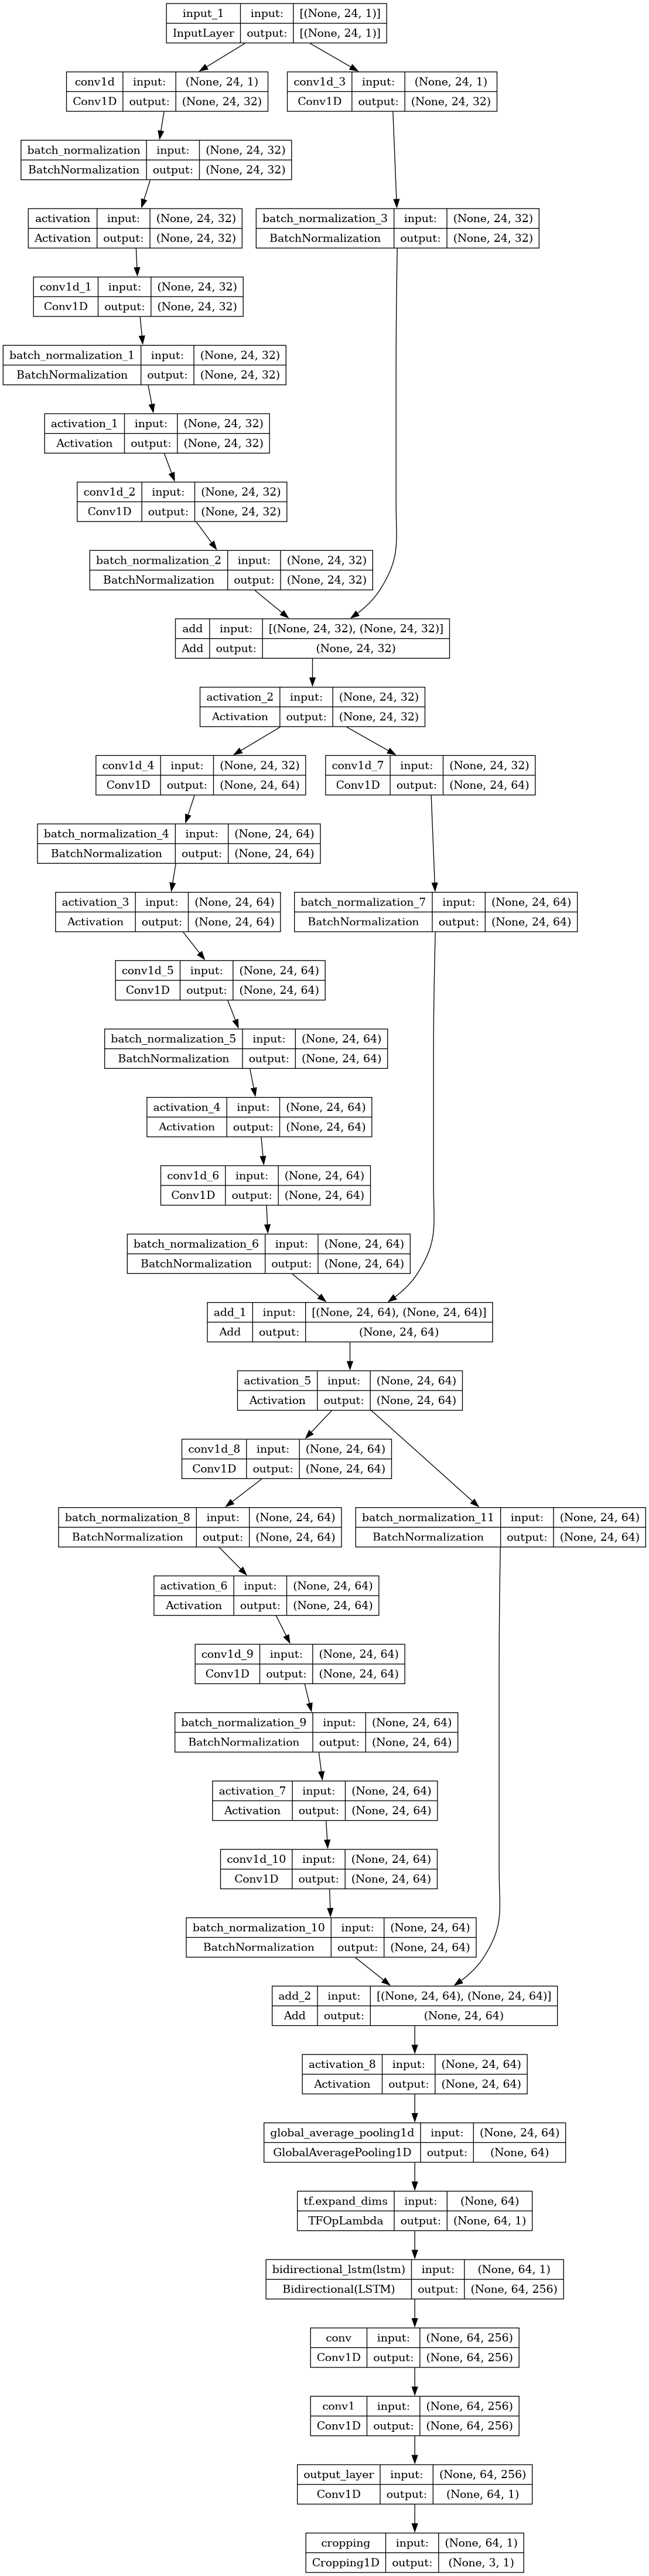

In [20]:
model = build_CONV_LSTM_model(input_shape, output_shape, n_features = 128)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [21]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/600
2273/2273 [==============================] - 228s 91ms/step - loss: 0.0070 - val_loss: 0.0061 - lr: 0.0010
Epoch 2/600
2273/2273 [==============================] - 205s 90ms/step - loss: 0.0060 - val_loss: 0.0058 - lr: 0.0010
Epoch 3/600
2273/2273 [==============================] - 206s 90ms/step - loss: 0.0058 - val_loss: 0.0058 - lr: 0.0010
Epoch 4/600
2273/2273 [==============================] - 207s 91ms/step - loss: 0.0057 - val_loss: 0.0057 - lr: 0.0010
Epoch 5/600
2273/2273 [==============================] - 206s 91ms/step - loss: 0.0056 - val_loss: 0.0058 - lr: 0.0010
Epoch 6/600
2273/2273 [==============================] - 206s 91ms/step - loss: 0.0055 - val_loss: 0.0060 - lr: 0.0010
Epoch 7/600
2273/2273 [==============================] - 206s 91ms/step - loss: 0.0055 - val_loss: 0.0056 - lr: 0.0010
Epoch 8/600
2273/2273 [==============================] - 206s 91ms/step - loss: 0.0054 - val_loss: 0.0055 - lr: 0.0010
Epoch 9/600
2273/2273 [=========================

In [22]:
model.save('forecasting_all_resnet.h5')